In [1]:
import pandas as pd
import numpy as np
import copy

from sklearn import preprocessing,svm
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import f1_score,accuracy_score,classification_report

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

## Methods used

In [2]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    return xx, yy

def custom_cv_kfolds(X,kFold):
    n = X.shape[0]
    i = 1
    while(i<=kFold): 
        idx = np.arange(n * (i - 1) / kFold, n * i / kFold, dtype=int)
        yield idx, idx
        i += 1

def getOnlyTwoClasses(X,Y,class_1,class_2):
    new_X, new_Y, j =[], [], 0
    for i in range(0,len(X)):
        if(Y[i]==class_1 or Y[i]==class_2):
            new_X.append(X[i])
            new_Y.append(Y[i])
            if(new_Y[j]==class_1):
                new_Y[j]=0
            if(new_Y[j]==class_2):
                new_Y[j]=1
            j+=1
    new_X, new_Y=np.asarray(new_X), np.asarray(new_Y)
    return new_X,new_Y

def getKFoldPartitions(X,Y,K): # X=dataX_train,Y=yTrain not dataY_train
    partitions_x, partitions_y = [], []
    for indices in custom_cv_kfolds(X,K):  # gets indices of partitions
        temp_X, temp_Y = [], []
        for i in indices[0]:
            temp_X.append(X[i])
            temp_Y.append(Y[i])  # yTrain, not dataY_train
        partitions_x.append(temp_X)
        partitions_y.append(temp_Y)
    return partitions_x, partitions_y

def plotBoundary(X,Y,model):
    Y = np.asarray(Y)
    X0, X1= X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
#     plt.scatter(X0, X1, c=Y)

    plt.xlabel('x1')
    plt.ylabel('x2')
    plot_decision_regions(X, Y, model, legend=2)
    plt.show()

def printScores(train_scores,validation_scores):
    print('\nScores:')
    for i in range(len(train_scores)):
        print('Class:',i,'\tTrainScore:',train_scores[i],' ValidationScore:', validation_scores[i])
    print()
        
def printAccuracies(train_acc,validation_acc):
    print('\nAccuracies')
    for i in range(len(train_acc)):
        print('Class:',i,'\tTrainAcc:',train_acc[i],' ValidationAcc:', validation_acc[i])
    print()

def accuracy(X,Y,model):
    yPred=model.predict(X)
    acc=accuracy_score(Y,yPred)
    print(classification_report(Y,yPred))
    return acc

### IRIS Dataset

In [3]:
data=pd.read_csv(r"C:\Users\Subhani\Documents\Jupyter AML\Assignments\Assignment_2\iris\iris-species\iris.csv")
data_classes={'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}

data_X=data.iloc[:,1:5].values
data_X=data.iloc[:,1:3].values ######## taken first 2 features
data_Y_names=data.iloc[:,5].values

data_Y=[]
for i in data_Y_names:
    data_Y.append(data_classes[i])

dataX_train, dataX_test, dataY_train, dataY_test = train_test_split(data_X, data_Y, test_size=0.2,random_state=20)
dataX_train.shape

(120, 2)

### Linear Kernel

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       0.74      0.79      0.77        39
           2       0.78      0.72      0.75        39

   micro avg       0.84      0.84      0.84       120
   macro avg       0.84      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.64      0.64      0.64        11
           2       0.64      0.64      0.64        11

   micro avg       0.73      0.73      0.73        30
   macro avg       0.76      0.76      0.76        30
weighted avg       0.73      0.73      0.73        30


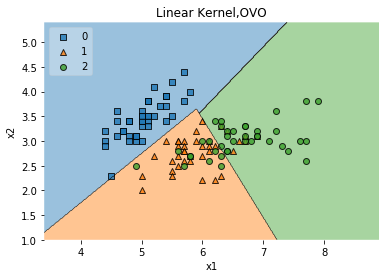

In [4]:
linearModel=svm.SVC(kernel='linear',decision_function_shape='ovo')
linearModel.fit(dataX_train, dataY_train)
print(linearModel)

trainAccuracy = accuracy(dataX_train, dataY_train, linearModel)
testAccuracy = accuracy(dataX_test, dataY_test, linearModel)
print('Train Accuracy:',trainAccuracy,'\nTest Accuracy:',testAccuracy)

X, Y = dataX_train, np.asarray(dataY_train)
name='Linear Kernel,OVO'
plt.title(name)
plotBoundary(X,Y,linearModel)

### OVO

In [5]:
def OVOTrain(X,Y):
    classifiers, train_scores, train_accuracy=[], [], []
    
    for classNumber_1 in range(0, len(data_classes)):
        class_models, class_train_scores, class_train_accuracy = [], [], []
        
        for classNumber_2 in range(classNumber_1+1, len(data_classes)):
            print('Class:', classNumber_1,' ',classNumber_2)

            xTrain, yTrain = getOnlyTwoClasses(X,Y,classNumber_1,classNumber_2)

            model = svm.SVC(kernel='linear')
            model.fit(xTrain,yTrain)
            
            name='Linear Kernel,OVO, class-'+str(classNumber_1)+','+str(classNumber_2)
            plt.title(name)
            plotBoundary(xTrain,yTrain,model)

            trainScore = model.score(xTrain,yTrain)
            yPred= model.predict(xTrain)
            trainAccuracy=accuracy_score(yTrain, yPred)

            class_models.append(model)
            class_train_scores.append(trainScore)
            class_train_accuracy.append(trainAccuracy)
        
        if(len(class_models)!=0):
            classifiers.append(class_models)
            train_scores.append(class_train_scores)
            train_accuracy.append(class_train_accuracy)
        
    return classifiers, train_scores, train_accuracy

def OVOValidation(X,Y,classifiers):
    validation_scores, validation_accuracies=[], []
    
    for classNumber_1 in range(0, len(data_classes)):
        class_validation_scores, class_validation_accuracy=[], []
        for classNumber_2 in range(classNumber_1+1, len(data_classes)):
            xTest, yTest = getOnlyTwoClasses(X,Y,classNumber_1,classNumber_2)

            for k in classifiers:
                for m in k:
                    validationScore = m.score(xTest, yTest)

                    yPred= m.predict(xTest)
                    validationAccuracy=accuracy_score(yTest, yPred)
                    
                    class_validation_scores.append(validationScore)
                    class_validation_accuracy.append(validationAccuracy)
                    
                validation_scores.append(class_validation_scores)
                validation_accuracies.append(class_validation_accuracy)
    return validation_scores, validation_accuracies

### OVO

Class: 0   1


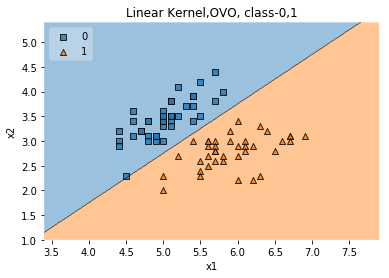

Class: 0   2


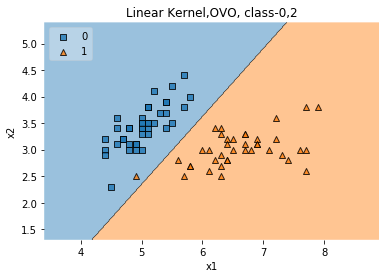

Class: 1   2


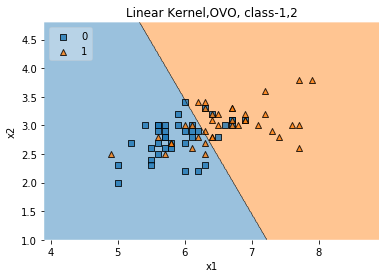


Scores:
Class: 0 	TrainScore: [1.0, 0.9876543209876543]  ValidationScore: [1.0, 0.8947368421052632, 0.631578947368421, 1.0, 1.0, 0.7894736842105263]
Class: 1 	TrainScore: [0.7564102564102564]  ValidationScore: [1.0, 0.8947368421052632, 0.631578947368421, 1.0, 1.0, 0.7894736842105263]


Accuracies
Class: 0 	TrainAcc: [1.0, 0.9876543209876543]  ValidationAcc: [1.0, 0.8947368421052632, 0.631578947368421, 1.0, 1.0, 0.7894736842105263]
Class: 1 	TrainAcc: [0.7564102564102564]  ValidationAcc: [1.0, 0.8947368421052632, 0.631578947368421, 1.0, 1.0, 0.7894736842105263]



In [6]:
classifiers, train_scores,train_accuracies = OVOTrain(dataX_train,dataY_train)
validation_scores, validation_accuracies = OVOValidation(dataX_test,dataY_test, classifiers)

printScores(train_scores,validation_scores)
printAccuracies(train_accuracies,validation_accuracies)